# Cryptocurrency Investments Trend and Decision Modeling

# Problem Statement

What opportunities exist as an individual investor to achieve a total return of at least 5% on all short-term cryptocurrency investments held less than 30 days by utilizing technical analysis, blockchain and social media metrics for price predictions?

# Context

Cryptocurrency coins are digital assets designed to work as a medium of exchange where ownership records are transactions are stored in a blockchain ledger using strong cryptography.  Cryptocurrencies typically use decentralized control as opposed to centralized digital currency and central banking systems.  Bitcoin was the first decentralized cryptocurrency formed in 2009 and per coinlore.com there are 5976 active coins trading today.

I was first introduced to cryptocurrencies by a former co-worker in 2017.  If I would have purchased 1 bitcoin in January 2017 for approximately $1000 it would be worth 36K as of today.  Honestly, I did not take it very serious at that time and I still prefer not to invest my life savings in cryptocurrencies.  However, I’m optimistic decentralized currencies have a future in our world so I’m going to use short-term profits to gain in USD but hold some coins for long term benefits.


# 3 Preprocessing<a id='3_preprocessing'></a>

In [1]:
# Import external libraries
import os
import sys
import json
import time
import math
from datetime import datetime
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Ignore warnings for clean output in notebook
import warnings
warnings.filterwarnings('ignore')

In [73]:
# Import local libraries
sys.path.append('..') # Add parent folder for local library imports

# Feature creation functions
from src.features.make_features import *
# Helper functions
from src.utils.helpers import *
# Visualization functions
from src.visuals.make_plots import *

# Load the "autoreload" extension so that code can change
%load_ext autoreload
#%reload_ext autoreload

# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 3.1 Load Data

In [3]:
# Directory references
data_interim_dir = r'..\data\interim'
data_final_dir = r'..\data\final'
model_save_dir = r'..\models'

In [4]:
# Read in Bitcoin data from interim data directory
btc = pd.read_csv(os.path.join(data_interim_dir, 'btc.csv'), parse_dates=['date'])
btc = btc.set_index('date')
btc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 718 entries, 2019-08-20 to 2021-08-06
Data columns (total 65 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   asset_id                 718 non-null    int64  
 1   time                     718 non-null    int64  
 2   open                     718 non-null    float64
 3   close                    718 non-null    float64
 4   high                     718 non-null    float64
 5   low                      718 non-null    float64
 6   volume                   718 non-null    float64
 7   market_cap               696 non-null    float64
 8   url_shares               710 non-null    float64
 9   unique_url_shares        710 non-null    float64
 10  tweets                   710 non-null    float64
 11  tweet_spam               710 non-null    float64
 12  tweet_followers          698 non-null    float64
 13  tweet_quotes             698 non-null    float64
 14  tweet_r

In [5]:
# Read in Dogecoin data from interim data directory
doge = pd.read_csv(os.path.join(data_interim_dir, 'doge.csv'), parse_dates=['date'])
doge = doge.set_index('date')
# Add in Bitcoin close price
doge['close_btc'] = btc['close']
doge.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 718 entries, 2019-08-20 to 2021-08-06
Data columns (total 66 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   asset_id                 718 non-null    int64  
 1   time                     718 non-null    int64  
 2   open                     718 non-null    float64
 3   close                    718 non-null    float64
 4   high                     718 non-null    float64
 5   low                      718 non-null    float64
 6   volume                   718 non-null    float64
 7   market_cap               696 non-null    float64
 8   url_shares               704 non-null    float64
 9   unique_url_shares        704 non-null    float64
 10  tweets                   710 non-null    float64
 11  tweet_spam               710 non-null    float64
 12  tweet_followers          698 non-null    float64
 13  tweet_quotes             698 non-null    float64
 14  tweet_r

# 3.2 Feature Engineering

In this section I will add in some custom time period merics for designated columns based on observations in the EDA phase.

###### Bitcoin

In [6]:
# Add technical anaysis single period metrics
btc = create_single_tp_metrics(btc, 14)
# Add technical analysis multi-period metrics
btc = create_multi_tp_metrics(btc, 12, 26, 9)
# Custom social transformations
custom_transform = [(['tweets', 'tweet_followers', 'tweet_sentiment_impact_net'], 'mean', 20),
                    (['news', 'volatility', 'social_volume_global'], 'mean', 14),
                    (['tweet_sentiment1', 'tweet_sentiment_impact_bearish'], 'stdev', 7),
                    (['market_dominance'], 'stdev', 14),
                   (['market_cap_global'], 'pct_change', 20)
                   ]
# Add social metrics
btc = create_social_metrics(btc, custom_transform)

# Save data to final data directory
btc.to_csv(os.path.join(data_final_dir, 'btc.csv'))

###### Dogecoin

In [7]:
# Add technical anaysis single period metrics
doge = create_single_tp_metrics(doge, 14)
# Add technical analysis multi-period metrics
doge = create_multi_tp_metrics(doge, 12, 26, 9)
# Custom social transformations
custom_transform = [(['tweets', 'tweet_followers', 'tweet_sentiment_impact_net'], 'mean', 20),
                    (['news', 'volatility', 'social_volume_global'], 'mean', 14),
                    (['tweet_sentiment1', 'tweet_sentiment_impact_bearish'], 'stdev', 7),
                    (['market_dominance'], 'stdev', 14),
                   (['market_cap_global'], 'pct_change', 20)
                   ]
# Add social metrics
doge = create_social_metrics(doge, custom_transform)

# Save data to final data directory
doge.to_csv(os.path.join(data_final_dir, 'doge.csv'))

# 3.3 Preprocessing

In this section I'm defining several key variables.  I will be making price predictions 1 day ahead for a total sequence of 7 days.  The total sequence length is 50 days.  This is a somewhat arbitrary choice and can be evaluated further later in the project.

In [8]:
# Define column for targets
target_col = 'close'
# Number of steps ahead to make prediction
steps_ahead = 1
# Input length for each sample
input_len = 49
# Total length for normalization window
total_len = input_len + steps_ahead
# Number of steps for regressive prediction sequences
prediction_len = 7
# Set number of periods for test data
test_periods = prediction_len * 10 + total_len

### 3.3.1 Normalization Methods

In this section I will create functions to perform preprocessing on the dataset and split into train, validation and test sets.  The preprocessing techniques that I will evaluate are:

1. Min-Max normalization (globally across entire dataset)
2. Standardization by removing the mean and scaling to unit variance (globally and across a defined window)
3. % Change normalization (globally and across a defined window)

Let's first visualize the distribution of the output data for the one dimensional dataset for each preprocessing methods

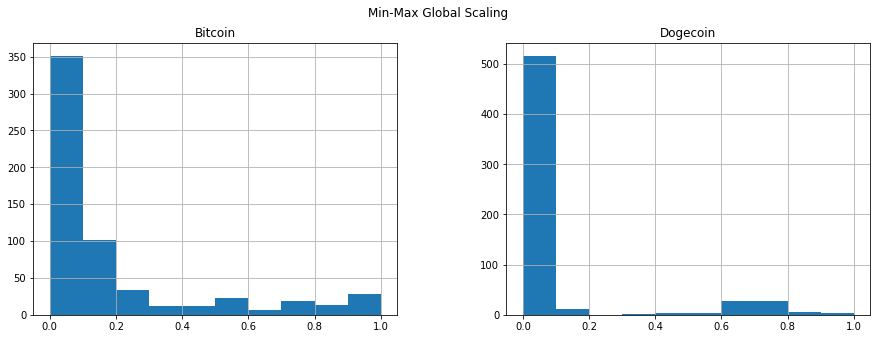

In [9]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()

cols = [target_col]
btc_data, btc_train_scaled_mm, btc_test_scaled_mm, btc_scaler_mm = data_preprocessing_scaling(minmax_scaler, btc, 
                                                                                     cols, test_periods)
doge_data, doge_train_scaled_mm, doge_test_scaled_mm, doge_scaler_mm = data_preprocessing_scaling(minmax_scaler, doge, 
                                                                                         cols, test_periods)

normalization_hist_plot((btc_train_scaled_mm, 'Bitcoin'), 
                        (doge_train_scaled_mm, 'Dogecoin'), 'Min-Max Global Scaling')

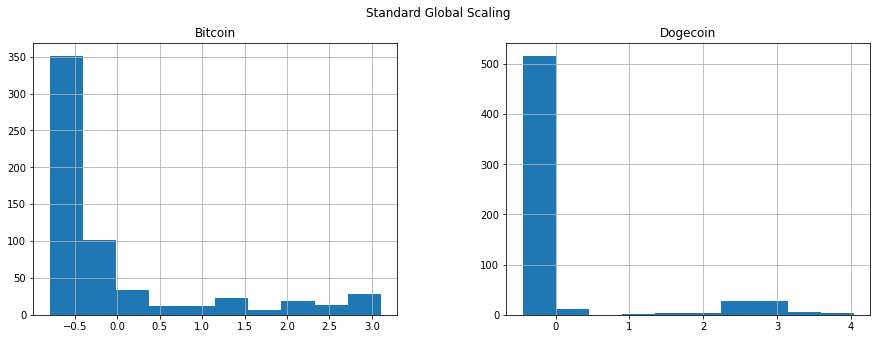

In [10]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()

btc_data, btc_train_scaled_sg, btc_test_scaled_sg, btc_scaler_sg = data_preprocessing_standardize(standard_scaler, btc, cols,
                                                                                         test_periods, -1)

doge_data, doge_train_scaled_sg, doge_test_scaled_sg, doge_scaler_sg = data_preprocessing_standardize(standard_scaler, doge, cols,
                                                                                         test_periods, -1)

normalization_hist_plot((btc_train_scaled_sg, 'Bitcoin'), 
                        (doge_train_scaled_sg, 'Dogecoin'), 'Standard Global Scaling')

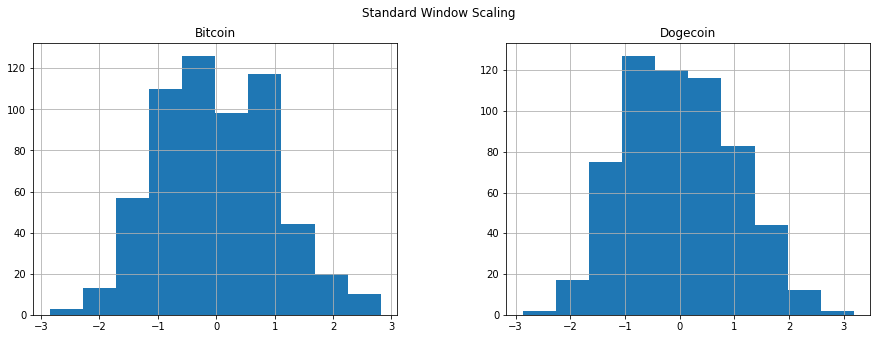

In [11]:
btc_data, btc_train_scaled_sw, btc_test_scaled_sw, btc_scaler_sw = data_preprocessing_standardize(standard_scaler, btc, cols,
                                                                                         test_periods, total_len)

doge_data, doge_train_scaled_sw, doge_test_scaled_sw, doge_scaler_sw = data_preprocessing_standardize(standard_scaler, doge, cols,
                                                                                         test_periods, total_len)

normalization_hist_plot((btc_train_scaled_sw, 'Bitcoin'), 
                        (doge_train_scaled_sw, 'Dogecoin'), 'Standard Window Scaling')

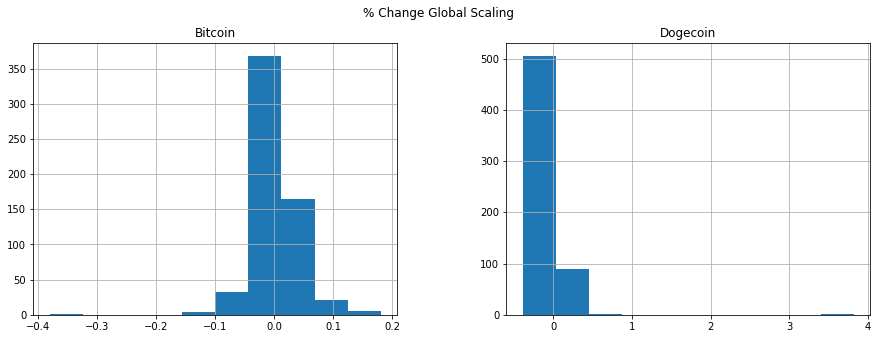

In [12]:
btc_data, btc_train_scaled_pg, btc_test_scaled_pg = data_preprocessing_pct_change(btc, cols, test_periods, -1)

doge_data, doge_train_scaled_pg, doge_test_scaled_pg = data_preprocessing_pct_change(doge, cols, test_periods, -1)

normalization_hist_plot((btc_train_scaled_pg, 'Bitcoin'), 
                        (doge_train_scaled_pg, 'Dogecoin'), '% Change Global Scaling')

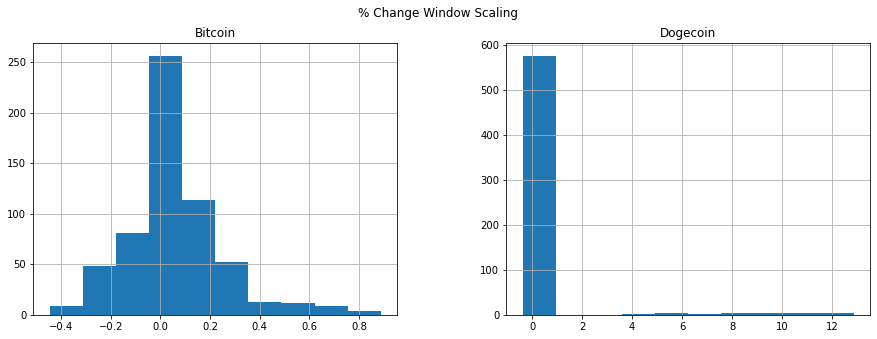

In [13]:
btc_data, btc_train_scaled_pw, btc_test_scaled_pw = data_preprocessing_pct_change(btc, cols, test_periods, total_len)

doge_data, doge_train_scaled_pw, doge_test_scaled_pw = data_preprocessing_pct_change(doge, cols, test_periods, total_len)

normalization_hist_plot((btc_train_scaled_pw, 'Bitcoin'), 
                        (doge_train_scaled_pw, 'Dogecoin'), '% Change Window Scaling')

Standard window scaling normalizes the data the best for both coins.  % Change window scaling normalizes the data very well for Bitcoin but since Dogecoin did not really have large changes in price until 2021 this scaling method is not as effective for Dogecoin.

# 4 Modeling<a id='4_modeling'></a>

## 4.1 Sequence Modeling

The first modeling task for this project is to utilize a Long short-term memory (LSTM) recurrent neural network to make sequence predictions for a future sequence of time steps.  In this case I'm focusing on the ending daily `close` price for each coin.  I'm not as concerned with being able to accurately predict the future `close` price but to be able to identify the directional trend.

In the first stage I will create several univariate LSTM models for Bitcoin and Dogecoin to determine the most effective normalization method and set baseline model performance.

The 4 evaluation metrics I will be using are:

1. `mean directional accuracy` - MDA utilizes the change in value (positive or negative) and averages if the predictions had the same directional change.  Higher is better.
2. `mean absolute error` - MAE averages the absolute value of the prediction error.  I will use this as the loss metric in the model.  Lower is better.
3. `mean absolute scaled error` - MASE uses MAE but scales the result by dividing by the MAE of actual data and a shifted forward naive forecast.  This metric will be scale invariant and allow me to compare the normalization methods across models.  Lower is better.
4. `accuracy` - This will be a sequence accuracy metric using a custom evaluation metric based on directional trend analysis.  The objective is to be able to predict the correct directional change while also being able to identify large % increase or decreases.

### 4.1.1 One-Dimensional LSTM Model

##### Bitcoin

Set some default configurations for the LSTM modeling process.

In [14]:
# Load LSTM model configuration params
lstm_config = json.load(open('lstm_config.json', 'r'))
lstm_config

{'model': {'loss': 'mae',
  'optimizer': {'learning_rate': 0.001,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07},
  'layers': [{'type': 'lstm', 'neurons': 100, 'return_seq': True},
   {'type': 'dropout', 'rate': 0.2},
   {'type': 'lstm', 'neurons': 100, 'return_seq': True},
   {'type': 'lstm', 'neurons': 100, 'return_seq': False},
   {'type': 'dropout', 'rate': 0.2},
   {'type': 'dense', 'neurons': 1, 'activation': 'linear'}]}}

In [15]:
btc_model_save_fname = os.path.join(model_save_dir, 'btc_lstm.h5')
# Create LSTM model training configuration params for Bitcoin
btc_train_config = dict(epochs=40,
                        batch_size=32,
                        validation_split=0.15,
                        verbose=1,
                        patience=3,
                        model_checkpoint=True,
                        save_fname=btc_model_save_fname
                       )
btc_train_config

{'epochs': 40,
 'batch_size': 32,
 'validation_split': 0.15,
 'verbose': 1,
 'patience': 3,
 'model_checkpoint': True,
 'save_fname': '..\\models\\btc_lstm.h5'}

#### 4.1.1.1 MinMax Scaling Global

In [16]:
from src.models.rnn_model import Model

btc_train_X, btc_train_y, btc_train_targets = create_timeseries_data(btc_train_scaled_mm, target_col, 
                                                                     input_len, steps_ahead)
btc_test_X, btc_test_y, btc_test_targets = create_timeseries_data(btc_test_scaled_mm, target_col, 
                                                                  input_len, steps_ahead)

print('Train X data shape:', btc_train_X.shape)
print('Train y data shape:', btc_train_y.shape)

# The input_timesteps and dim will vary depending on the data so add this to the configs based on the data
btc_model_config = update_model_input_dim(lstm_config, btc_train_X.shape, btc_train_y.shape)

# Instantiate model class
btc_lstm_model = Model()

# Build model
btc_lstm_model.build_model(btc_model_config)

btc_lstm_model.train(btc_train_X, btc_train_y, btc_train_config)

Train X data shape: (549, 49, 1)
Train y data shape: (549, 1)
Epoch 1/40
15/15 [==============================] - 6s 151ms/step - loss: 0.0370 - val_loss: 0.4041
Epoch 2/40
15/15 [==============================] - 1s 72ms/step - loss: 0.0188 - val_loss: 0.2262
Epoch 3/40
15/15 [==============================] - 1s 79ms/step - loss: 0.0179 - val_loss: 0.3997
Epoch 4/40
15/15 [==============================] - 1s 70ms/step - loss: 0.0163 - val_loss: 0.2203
Epoch 5/40
15/15 [==============================] - 1s 70ms/step - loss: 0.0163 - val_loss: 0.4774
Epoch 6/40
15/15 [==============================] - 1s 70ms/step - loss: 0.0170 - val_loss: 0.2375
Epoch 7/40
15/15 [==============================] - 1s 70ms/step - loss: 0.0151 - val_loss: 0.1336
Epoch 8/40
15/15 [==============================] - 1s 79ms/step - loss: 0.0182 - val_loss: 0.2564
Epoch 9/40
15/15 [==============================] - 1s 70ms/step - loss: 0.0171 - val_loss: 0.1451
Epoch 10/40
15/15 [===========================

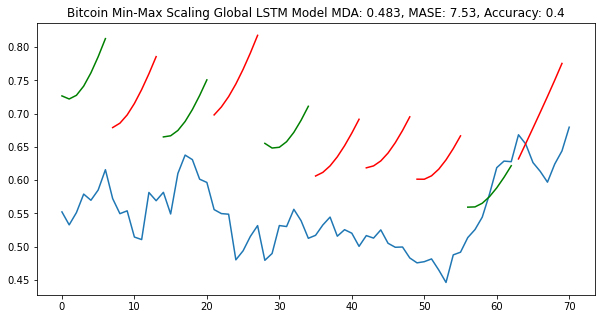

In [17]:
btc_predictions, btc_seq_metrics = evaluate_model(btc_lstm_model, btc_test_X, btc_test_y, 
                                                  total_len, prediction_len, steps_ahead)

# Capture baseline metrics for min-max scaler
btc_base_mm_mda = mean_metric_results(btc_seq_metrics, 'mda')
btc_base_mm_mase = mean_metric_results(btc_seq_metrics, 'mase')
btc_base_mm_acc = mean_accuracy(btc_seq_metrics)

title = 'Bitcoin Min-Max Scaling Global LSTM Model MDA: {:.3}, MASE: {:.3}, Accuracy: {:.3}'.format(btc_base_mm_mda, 
                                                                                                    btc_base_mm_mase, 
                                                                                                    btc_base_mm_acc)

plot_results_multiple(btc_predictions, btc_test_y, prediction_len, title)

Performance is generally very poor using Min-Max scaling with the predictions being completely off the mark but the trend detection is correct on several sequences.

#### 4.1.1.2 Standard Scaler Global

In [18]:
btc_train_X, btc_train_y, btc_train_targets = create_timeseries_data(btc_train_scaled_sg, target_col, 
                                                                     input_len, steps_ahead)
btc_test_X, btc_test_y, btc_test_targets = create_timeseries_data(btc_test_scaled_sg, target_col, 
                                                                  input_len, steps_ahead)

print('Train X data shape:', btc_train_X.shape)
print('Train y data shape:', btc_train_y.shape)

# The input_timesteps and dim will vary depending on the data so add this to the configs based on the data
btc_model_config = update_model_input_dim(lstm_config, btc_train_X.shape, btc_train_y.shape)

# Instantiate model class
btc_lstm_model = Model()

# Build model
btc_lstm_model.build_model(btc_model_config)

btc_lstm_model.train(btc_train_X, btc_train_y, btc_train_config)

Train X data shape: (549, 49, 1)
Train y data shape: (549, 1)
Epoch 1/40
15/15 [==============================] - 6s 128ms/step - loss: 0.1418 - val_loss: 0.3110
Epoch 2/40
15/15 [==============================] - 1s 75ms/step - loss: 0.0752 - val_loss: 0.4877
Epoch 3/40
15/15 [==============================] - 1s 80ms/step - loss: 0.0661 - val_loss: 0.3947
Epoch 4/40
15/15 [==============================] - 1s 73ms/step - loss: 0.0615 - val_loss: 0.3707


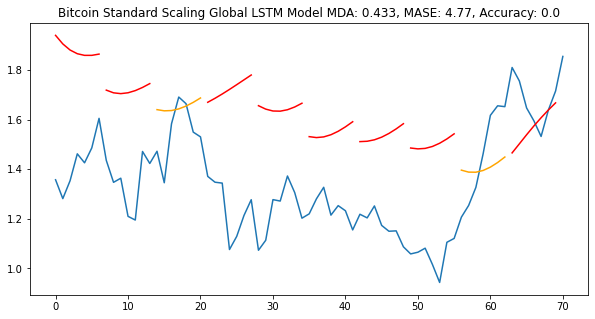

In [19]:
btc_predictions, btc_seq_metrics = evaluate_model(btc_lstm_model, btc_test_X, btc_test_y, 
                                                  total_len, prediction_len, steps_ahead)

btc_base_sg_mda = mean_metric_results(btc_seq_metrics, 'mda')
btc_base_sg_mase = mean_metric_results(btc_seq_metrics, 'mase')
btc_base_sg_acc = mean_accuracy(btc_seq_metrics)

title = 'Bitcoin Standard Scaling Global LSTM Model MDA: {:.3}, MASE: {:.3}, Accuracy: {:.3}'.format(btc_base_sg_mda, 
                                                                                                     btc_base_sg_mase,
                                                                                                     btc_base_sg_acc)
plot_results_multiple(btc_predictions, btc_test_y, prediction_len, title)

The predictions for standard scaling global are quite similar to Min-Max scaling.

#### 4.1.1.3 Standard Scaler Window

In [20]:
btc_train_X, btc_train_y, btc_train_targets = create_timeseries_data(btc_train_scaled_sw, target_col, 
                                                                     input_len, steps_ahead)
btc_test_X, btc_test_y, btc_test_targets = create_timeseries_data(btc_test_scaled_sw, target_col, 
                                                                  input_len, steps_ahead)

print('Train X data shape:', btc_train_X.shape)
print('Train y data shape:', btc_train_y.shape)

# The input_timesteps and dim will vary depending on the data so add this to the configs based on the data
btc_model_config = update_model_input_dim(lstm_config, btc_train_X.shape, btc_train_y.shape)

# Instantiate model class
btc_lstm_model = Model()

# Build model
btc_lstm_model.build_model(btc_model_config)

btc_lstm_model.train(btc_train_X, btc_train_y, btc_train_config)

Train X data shape: (549, 49, 1)
Train y data shape: (549, 1)
Epoch 1/40
15/15 [==============================] - 6s 134ms/step - loss: 0.7203 - val_loss: 0.7427
Epoch 2/40
15/15 [==============================] - 1s 98ms/step - loss: 0.6736 - val_loss: 0.7735
Epoch 3/40
15/15 [==============================] - 2s 157ms/step - loss: 0.6314 - val_loss: 0.6530
Epoch 4/40
15/15 [==============================] - 2s 141ms/step - loss: 0.5813 - val_loss: 0.5785
Epoch 5/40
15/15 [==============================] - 2s 141ms/step - loss: 0.5538 - val_loss: 0.5453
Epoch 6/40
15/15 [==============================] - 2s 144ms/step - loss: 0.5361 - val_loss: 0.4907
Epoch 7/40
15/15 [==============================] - 2s 137ms/step - loss: 0.4977 - val_loss: 0.4597
Epoch 8/40
15/15 [==============================] - 2s 149ms/step - loss: 0.4736 - val_loss: 0.4649
Epoch 9/40
15/15 [==============================] - 2s 155ms/step - loss: 0.4269 - val_loss: 0.3899
Epoch 10/40
15/15 [====================

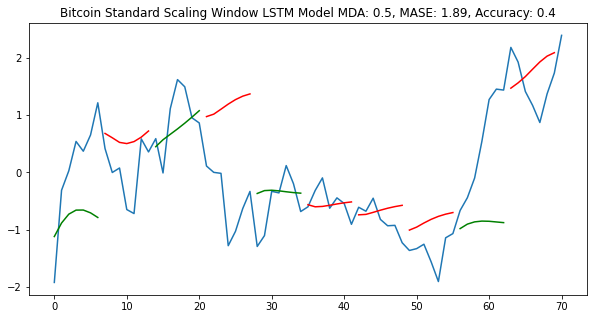

In [21]:
btc_predictions, btc_seq_metrics = evaluate_model(btc_lstm_model, btc_test_X, btc_test_y, 
                                                  total_len, prediction_len, steps_ahead)

btc_base_sw_mda = mean_metric_results(btc_seq_metrics, 'mda')
btc_base_sw_mase = mean_metric_results(btc_seq_metrics, 'mase')
btc_base_sw_acc = mean_accuracy(btc_seq_metrics)

title = 'Bitcoin Standard Scaling Window LSTM Model MDA: {:.3}, MASE: {:.3}, Accuracy: {:.3}'.format(btc_base_sw_mda, 
                                                                                                     btc_base_sw_mase,
                                                                                                     btc_base_sw_acc)
plot_results_multiple(btc_predictions, btc_test_y, prediction_len, title)

Standard scaling across a window generally performs much better then the prior 2 methods.  Looking at the predictions these are much more accurate than prior scaling methods and this method had the highest sequence trend accuracy so far.  Window standard scalling will be explored further with Dogecoin.

#### 4.1.1.4 Percentage Change Global

In [22]:
btc_train_X, btc_train_y, btc_train_targets = create_timeseries_data(btc_train_scaled_pg, target_col, 
                                                                     input_len, steps_ahead)
btc_test_X, btc_test_y, btc_test_targets = create_timeseries_data(btc_test_scaled_pg, target_col, 
                                                                  input_len, steps_ahead)

print('Train X data shape:', btc_train_X.shape)
print('Train y data shape:', btc_train_y.shape)

# The input_timesteps and dim will vary depending on the data so add this to the configs based on the data
btc_model_config = update_model_input_dim(lstm_config, btc_train_X.shape, btc_train_y.shape)

# Instantiate model class
btc_lstm_model = Model()

# Build model
btc_lstm_model.build_model(btc_model_config)

btc_lstm_model.train(btc_train_X, btc_train_y, btc_train_config)

Train X data shape: (548, 49, 1)
Train y data shape: (548, 1)
Epoch 1/40
15/15 [==============================] - 8s 231ms/step - loss: 0.0252 - val_loss: 0.0302
Epoch 2/40
15/15 [==============================] - 2s 150ms/step - loss: 0.0251 - val_loss: 0.0300
Epoch 3/40
15/15 [==============================] - 2s 148ms/step - loss: 0.0253 - val_loss: 0.0312
Epoch 4/40
15/15 [==============================] - 2s 141ms/step - loss: 0.0253 - val_loss: 0.0299
Epoch 5/40
15/15 [==============================] - 2s 149ms/step - loss: 0.0247 - val_loss: 0.0300
Epoch 6/40
15/15 [==============================] - 2s 142ms/step - loss: 0.0251 - val_loss: 0.0304
Epoch 7/40
15/15 [==============================] - 2s 137ms/step - loss: 0.0251 - val_loss: 0.0303


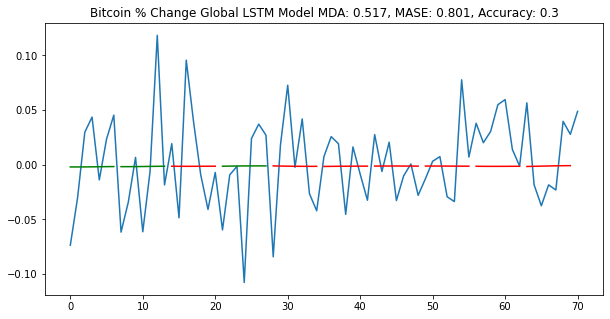

In [23]:
btc_predictions, btc_seq_metrics = evaluate_model(btc_lstm_model, btc_test_X, btc_test_y, 
                                                  total_len, prediction_len, steps_ahead)

btc_base_pg_mda = mean_metric_results(btc_seq_metrics, 'mda')
btc_base_pg_mase = mean_metric_results(btc_seq_metrics, 'mase')
btc_base_pg_acc = mean_accuracy(btc_seq_metrics)

title = 'Bitcoin % Change Global LSTM Model MDA: {:.3}, MASE: {:.3}, Accuracy: {:.3}'.format(btc_base_pg_mda, 
                                                                                             btc_base_pg_mase,
                                                                                            btc_base_pg_acc)
plot_results_multiple(btc_predictions, btc_test_y, prediction_len, title)

% Change globally is clearly the worst performing.  The sequence predictions are almost completely flat.  This also highlights the weakness with all 3 metrics and essentially acts like a naive baseline model to just predict there will be no change in price.

#### 4.1.1.5 Percentage Change Window

In [24]:
btc_train_X, btc_train_y, btc_train_targets = create_timeseries_data(btc_train_scaled_pw, target_col, 
                                                                     input_len, steps_ahead)
btc_test_X, btc_test_y, btc_test_targets = create_timeseries_data(btc_test_scaled_pw, target_col, 
                                                                  input_len, steps_ahead)

print('Train X data shape:', btc_train_X.shape)
print('Train y data shape:', btc_train_y.shape)

# The input_timesteps and dim will vary depending on the data so add this to the configs based on the data
btc_model_config = update_model_input_dim(lstm_config, btc_train_X.shape, btc_train_y.shape)


# Instantiate model class
btc_lstm_model = Model()

# Build model
btc_lstm_model.build_model(btc_model_config)

btc_lstm_model.train(btc_train_X, btc_train_y, btc_train_config)

Train X data shape: (549, 49, 1)
Train y data shape: (549, 1)
Epoch 1/40
15/15 [==============================] - 7s 206ms/step - loss: 0.1054 - val_loss: 0.1711
Epoch 2/40
15/15 [==============================] - 2s 145ms/step - loss: 0.0823 - val_loss: 0.1407
Epoch 3/40
15/15 [==============================] - 2s 141ms/step - loss: 0.0786 - val_loss: 0.1284
Epoch 4/40
15/15 [==============================] - 2s 136ms/step - loss: 0.0735 - val_loss: 0.1071
Epoch 5/40
15/15 [==============================] - 2s 145ms/step - loss: 0.0680 - val_loss: 0.1011
Epoch 6/40
15/15 [==============================] - 2s 126ms/step - loss: 0.0627 - val_loss: 0.0876
Epoch 7/40
15/15 [==============================] - 2s 126ms/step - loss: 0.0613 - val_loss: 0.0816
Epoch 8/40
15/15 [==============================] - 2s 142ms/step - loss: 0.0585 - val_loss: 0.0795
Epoch 9/40
15/15 [==============================] - 2s 127ms/step - loss: 0.0534 - val_loss: 0.0781
Epoch 10/40
15/15 [===================

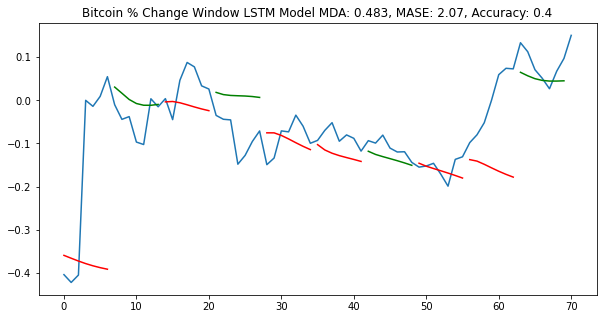

In [25]:
btc_predictions, btc_seq_metrics = evaluate_model(btc_lstm_model, btc_test_X, btc_test_y, 
                                                  total_len, prediction_len, steps_ahead)

btc_base_pw_mda = mean_metric_results(btc_seq_metrics, 'mda')
btc_base_pw_mase = mean_metric_results(btc_seq_metrics, 'mase')
btc_base_pw_acc = mean_accuracy(btc_seq_metrics)

title = 'Bitcoin % Change Window LSTM Model MDA: {:.3}, MASE: {:.3}, Accuracy: {:.3}'.format(btc_base_pw_mda, 
                                                                                             btc_base_pw_mase,
                                                                                            btc_base_pw_acc)
plot_results_multiple(btc_predictions, btc_test_y, prediction_len, title)

##### Training Runs

Due to stochastic nature of a rnn model training, the results can vary for each run so next I will train a model for Standard and % Change window scalling multiple times and then average the evaluation metrics.

##### Bitcoin

In [26]:
# Train and evaluate model for specified training runs
def model_training_runs(training_runs, model_config, train_config, train_X, train_y, test_X, test_y, 
                        total_len, prediction_len, steps_ahead, verbose=True):
    training_run_results = []
    for i in range(training_runs):
        # Instantiate model class
        lstm_model = Model()
        # Build model
        lstm_model.build_model(model_config)
        if verbose:
            print('Model Training started for instance {}'.format(i+1))
        # Train model
        lstm_model.train(train_X, train_y, train_config)
        # Evaluate model
        predictions, seq_metrics = evaluate_model(lstm_model, test_X, test_y, total_len, prediction_len, steps_ahead)
        # Append results
        training_run_results.append(seq_metrics)
    return training_run_results

In [27]:
training_runs = 10

# Recreate train/test data with standard window scaled data
btc_train_X, btc_train_y, btc_train_targets = create_timeseries_data(btc_train_scaled_sw, target_col, 
                                                                     input_len, steps_ahead)
btc_test_X, btc_test_y, btc_test_targets = create_timeseries_data(btc_test_scaled_sw, target_col, 
                                                                  input_len, steps_ahead)

# Turn off verbose since training multiple models
btc_train_config['verbose'] = 0

btc_model_config = update_model_input_dim(lstm_config, btc_train_X.shape, btc_train_y.shape)

btc_sw_results = model_training_runs(training_runs, btc_model_config, btc_train_config, 
                                     btc_train_X, btc_train_y, 
                                     btc_test_X, btc_test_y, 
                                     total_len, prediction_len, steps_ahead)

Model Training started for instance 1
Model Training started for instance 2
Model Training started for instance 3
Model Training started for instance 4
Model Training started for instance 5
Model Training started for instance 6
Model Training started for instance 7
Model Training started for instance 8
Model Training started for instance 9
Model Training started for instance 10


In [28]:
btc_base_sw_mda = mean_metric_seq_results(btc_sw_results, 'mda')
btc_base_sw_mase = mean_metric_seq_results(btc_sw_results, 'mase')
btc_base_sw_acc = mean_accuracy_seq(btc_sw_results)
print('Bitcoin Standard Scaling Window Baseline Metrics MDA: {:.3}, MASE: {:.3}, Accuracy: {:.3}.'.\
format(btc_base_sw_mda, btc_base_sw_mase, btc_base_sw_acc))

Bitcoin Standard Scaling Window Baseline Metrics MDA: 0.547, MASE: 1.87, Accuracy: 0.48.


In [29]:
# Recreate train/test data with % change window scaled data
btc_train_X, btc_train_y, btc_train_targets = create_timeseries_data(btc_train_scaled_pw, target_col, 
                                                                     input_len, steps_ahead)
btc_test_X, btc_test_y, btc_test_targets = create_timeseries_data(btc_test_scaled_pw, target_col, 
                                                                  input_len, steps_ahead)

# Turn off verbose since training multiple models
btc_train_config['verbose'] = 0

btc_model_config = update_model_input_dim(lstm_config, btc_train_X.shape, btc_train_y.shape)

btc_pw_results = model_training_runs(training_runs, btc_model_config, btc_train_config, 
                                     btc_train_X, btc_train_y, 
                                     btc_test_X, btc_test_y, 
                                     total_len, prediction_len, steps_ahead)

Model Training started for instance 1
Model Training started for instance 2
Model Training started for instance 3
Model Training started for instance 4
Model Training started for instance 5
Model Training started for instance 6
Model Training started for instance 7
Model Training started for instance 8
Model Training started for instance 9
Model Training started for instance 10


In [30]:
btc_base_pw_mda = mean_metric_seq_results(btc_pw_results, 'mda')
btc_base_pw_mase = mean_metric_seq_results(btc_pw_results, 'mase')
btc_base_pw_acc = mean_accuracy_seq(btc_pw_results)
print('Bitcoin % Change Scaling Window Baseline Metrics MDA: {:.3}, MASE: {:.3}, Accuracy: {:.3}.'.\
format(btc_base_pw_mda, btc_base_pw_mase, btc_base_pw_acc))

Bitcoin % Change Scaling Window Baseline Metrics MDA: 0.537, MASE: 1.98, Accuracy: 0.49.


##### Dogecoin

This will be the first time creating a model for Dogecoin so need to create the datasets and configs.

In [31]:
# Create train/test data for doge
doge_train_X, doge_train_y, doge_train_targets = create_timeseries_data(doge_train_scaled_sw, target_col, 
                                                                        input_len, steps_ahead)
doge_test_X, doge_test_y, doge_test_targets = create_timeseries_data(doge_test_scaled_sw, target_col, 
                                                  input_len, steps_ahead)

print('Train data shape:', doge_train_X.shape)
print('Train y shape:', doge_test_y.shape)

Train data shape: (549, 49, 1)
Train y shape: (71, 1)


In [32]:
# The input_timesteps and dim will vary depending on the data so add this to the configs based on the data
doge_model_config = update_model_input_dim(lstm_config, doge_train_X.shape, doge_test_y.shape)
doge_model_config

{'model': {'loss': 'mae',
  'optimizer': {'learning_rate': 0.001,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07},
  'layers': [{'type': 'lstm',
    'neurons': 100,
    'return_seq': True,
    'input_timesteps': 49,
    'input_dim': 1},
   {'type': 'dropout', 'rate': 0.2},
   {'type': 'lstm', 'neurons': 100, 'return_seq': True},
   {'type': 'lstm', 'neurons': 100, 'return_seq': False},
   {'type': 'dropout', 'rate': 0.2},
   {'type': 'dense', 'neurons': 1, 'activation': 'linear'}]}}

In [33]:
doge_model_save_fname = os.path.join(model_save_dir, 'doge_lstm.h5')
# Create LSTM model training configuration params for Dogecoin
doge_train_config = dict(epochs=40,
                        batch_size=32,
                        validation_split=0.15,
                        verbose=0,
                        patience=3,
                        model_checkpoint=True,
                        save_fname=doge_model_save_fname
                       )
doge_train_config

{'epochs': 40,
 'batch_size': 32,
 'validation_split': 0.15,
 'verbose': 0,
 'patience': 3,
 'model_checkpoint': True,
 'save_fname': '..\\models\\doge_lstm.h5'}

In [34]:
doge_sw_results = model_training_runs(training_runs, doge_model_config, doge_train_config, 
                                     doge_train_X, doge_train_y, 
                                     doge_test_X, doge_test_y, 
                                     total_len, prediction_len, steps_ahead)

Model Training started for instance 1
Model Training started for instance 2
Model Training started for instance 3
Model Training started for instance 4
Model Training started for instance 5
Model Training started for instance 6
Model Training started for instance 7
Model Training started for instance 8
Model Training started for instance 9
Model Training started for instance 10


In [37]:
doge_base_sw_mda = mean_metric_seq_results(doge_sw_results, 'mda')
doge_base_sw_mase = mean_metric_seq_results(doge_sw_results, 'mase')
doge_base_sw_acc = mean_accuracy_seq(doge_sw_results)
print('Dogecoin Standard Scaling Window Baseline Metrics MDA: {:.3}, MASE: {:.3}, Accuracy: {:.3}.'.\
format(doge_base_sw_mda, doge_base_sw_mase, doge_base_sw_acc))

Dogecoin Standard Scaling Window Baseline Metrics MDA: 0.5, MASE: 5.22, Accuracy: 0.62.


In [36]:
# Create train/test data for doge
doge_train_X, doge_train_y, doge_train_targets = create_timeseries_data(doge_train_scaled_pw, target_col, 
                                                                        input_len, steps_ahead)
doge_test_X, doge_test_y, doge_test_targets = create_timeseries_data(doge_test_scaled_pw, target_col, 
                                                  input_len, steps_ahead)

print('Train data shape:', doge_train_X.shape)
print('Train y shape:', doge_test_y.shape)

# Turn off verbose since training multiple models
doge_train_config['verbose'] = 0
doge_model_config = update_model_input_dim(lstm_config, doge_train_X.shape, doge_test_y.shape)

doge_pw_results = model_training_runs(training_runs, doge_model_config, doge_train_config, 
                                     doge_train_X, doge_train_y, 
                                     doge_test_X, doge_test_y, 
                                     total_len, prediction_len, steps_ahead)

Train data shape: (549, 49, 1)
Train y shape: (71, 1)
Model Training started for instance 1
Model Training started for instance 2
Model Training started for instance 3
Model Training started for instance 4
Model Training started for instance 5
Model Training started for instance 6
Model Training started for instance 7
Model Training started for instance 8
Model Training started for instance 9
Model Training started for instance 10


In [38]:
doge_base_pw_mda = mean_metric_seq_results(doge_pw_results, 'mda')
doge_base_pw_mase = mean_metric_seq_results(doge_pw_results, 'mase')
doge_base_pw_acc = mean_accuracy_seq(doge_sw_results)
print('Dogecoin % Change Scaling Window Baseline Metrics MDA: {:.3}, MASE: {:.3}, Accuracy: {:.3}.'.\
format(doge_base_pw_mda, doge_base_pw_mase, doge_base_pw_acc))

Dogecoin % Change Scaling Window Baseline Metrics MDA: 0.528, MASE: 7.88, Accuracy: 0.62.


I will utilize Standard scaling windows moving forward.  Standard scaling normalized the data better for Dogecoin so appears to be a more generalized approach to be applied to future coins.  The difference between Standard and % Change window scaling is pretty minimal so may consider using % Change window scaling in the future depending on the coin.

### 4.1.2 Multi-Dimensional LSTM Model

I have over 100 features so instead of using all in a multi-dimensional model I will train a model with each incrementally added to `close` and then evaluate if the feature improves from the baseline one-dimensional model.  I will then select the features for each Bitcoin and Dogecoin model.

##### Bitcoin

In [39]:
btc_search_cols = list(btc.drop(['asset_id', 'time', 'open', 'close', 'name', 'symbol', 'price_btc',
                             'close_end_1d', 'close_percent_change_1d', 'close_end_7d', 'close_min_7d', 
                             'close_max_7d', 'close_loss_7d', 'close_gain_7d', 'close_change_7d', 
                             'close_percent_change_7d', 'decision','color','angle', 'intercept']
                            , axis=1).columns)

In [41]:
def model_training_search_cols(search_cols, training_runs, target_col, scaler, df, 
                               test_periods, input_len, total_len, prediction_len, steps_ahead,
                              train_config, baseline, verbose=False):
    search_results = {}
    for col in search_cols:
        cols = [*[target_col], *[col]]
        try:
            # Scale data based on new cols list
            data, train_scaled, test_scaled, scalers = data_preprocessing_standardize(scaler, df, cols, test_periods, 
                                                                                      total_len)

            # Create train/test datasets
            train_X, train_y, train_targets = create_timeseries_data(train_scaled, target_col, input_len, steps_ahead)
            test_X, test_y, test_targets = create_timeseries_data(test_scaled, target_col, input_len, steps_ahead)

            model_config = update_model_input_dim(lstm_config, train_X.shape, train_y.shape)

            run_results = model_training_runs(training_runs, model_config, train_config, 
                                              train_X, train_y,
                                              test_X, test_y,
                                              total_len, prediction_len, steps_ahead,
                                              verbose=False) # Always False for training runs due # of lines in output

            mda = mean_metric_seq_results(run_results, 'mda')
            mase = mean_metric_seq_results(run_results, 'mase')
            acc = mean_accuracy_seq(run_results)

            # Save results
            search_results[col] = {'mda': mda, 'mase': mase, 'accuracy': acc}

            if acc > baseline or verbose:
                print('LSTM model trained with "' + 
                      col + '". {} training run(s) trend accuracy of {:.3}.'.format(training_runs, acc))
        except:
            print('Unable to train model for "' + col + '".')
    return search_results

In [42]:
# Set verbose to off since training many models
btc_train_config['verbose'] = 0
# For the first run for all columns set training runs to 1
training_runs = 1
btc_search_results = model_training_search_cols(btc_search_cols, training_runs, target_col, standard_scaler, btc, 
                                                test_periods, input_len, total_len, prediction_len, steps_ahead,
                                                btc_train_config, btc_base_sw_acc)

LSTM model trained with "high". 1 training run(s) trend accuracy of 0.5.
LSTM model trained with "volume". 1 training run(s) trend accuracy of 0.5.
LSTM model trained with "url_shares". 1 training run(s) trend accuracy of 0.6.
LSTM model trained with "tweets". 1 training run(s) trend accuracy of 0.5.
LSTM model trained with "tweet_spam". 1 training run(s) trend accuracy of 0.6.
LSTM model trained with "tweet_sentiment2". 1 training run(s) trend accuracy of 0.6.
LSTM model trained with "tweet_sentiment3". 1 training run(s) trend accuracy of 0.6.
LSTM model trained with "tweet_sentiment4". 1 training run(s) trend accuracy of 0.5.
LSTM model trained with "tweet_sentiment5". 1 training run(s) trend accuracy of 0.5.
LSTM model trained with "tweet_sentiment_impact1". 1 training run(s) trend accuracy of 0.5.
LSTM model trained with "tweet_sentiment_impact2". 1 training run(s) trend accuracy of 0.5.
LSTM model trained with "tweet_sentiment_impact3". 1 training run(s) trend accuracy of 0.5.
LST

In [43]:
btc_search_results_df = pd.DataFrame(btc_search_results).T

# Top 10 by accuracy
btc_search_results_df.sort_values(by='accuracy', ascending=False).head(10)

,mda,mase,accuracy
social_volume_24h_rank,0.550000,2.169999,0.7
volume_24h_rank,0.633333,1.969215,0.7
percent_change_24h_rank,0.583333,1.986021,0.7
youtube,0.566667,1.940532,0.7
dx,0.633333,1.700796,0.7
tweets_mean,0.700000,1.726347,0.7
tweet_sentiment3,0.633333,1.799785,0.6
medium,0.650000,1.889134,0.6
alt_rank,0.483333,1.887370,0.6
social_volume,0.583333,2.099818,0.6


In [44]:
# Top 10 by mda
btc_search_results_df.sort_values(by='mda', ascending=False).head(10)

,mda,mase,accuracy
tweets_mean,0.700000,1.726347,0.7
volatility_mean,0.666667,1.889638,0.4
medium,0.650000,1.889134,0.6
tweets,0.650000,1.653568,0.5
tweet_sentiment3,0.633333,1.799785,0.6
volume_24h_rank,0.633333,1.969215,0.7
tweet_sentiment_net,0.633333,1.707847,0.5
market_dominance_stdev,0.633333,1.784093,0.5
dx,0.633333,1.700796,0.7
tweet_sentiment_bearish,0.616667,1.580976,0.4


In [45]:
# Top 10 by mase
btc_search_results_df.sort_values(by='mase', ascending=True).head(10)

,mda,mase,accuracy
tweet_sentiment_bearish,0.616667,1.580976,0.4
market_cap_global_pct_change,0.583333,1.623651,0.5
tweets,0.650000,1.653568,0.5
social_volume_global,0.583333,1.674126,0.5
dx,0.633333,1.700796,0.7
tweet_sentiment_net,0.633333,1.707847,0.5
tweets_mean,0.700000,1.726347,0.7
news_mean,0.583333,1.726599,0.6
tweet_spam,0.600000,1.780938,0.6
market_dominance_stdev,0.633333,1.784093,0.5


Next I will reduce the search space based on the single run results as well as observations in the EDA stage.  I will increase the training runs to identify the features that improve the model from the baseline.

In [48]:
# Manually construct list of columns to search for final
btc_search_final_cols = ['linreg', 'dx',
                         'market_cap_global', 'market_cap_global_pct_change',
                         'market_dominance', 'market_dominance_stdev',
                         'percent_change_24h_rank', 'social_volume_24h_rank', 'volume_24h_rank',
                         'social_score_24h_rank', 'social_volume_global', 'social_contributors', 
                         'news_mean', 'volatility_mean', 'tweets_mean',
                         'tweet_sentiment_impact_bearish', 'tweet_sentiment_impact_bullish', 
                         'tweet_sentiment_net', 'tweet_sentiment_bearish', 'tweet_sentiment_bullish'
                        ]
print(len(btc_search_final_cols))

20


In [49]:
# Set verbose to off since training many models
btc_train_config['verbose'] = 0
# Do not run checkpoints
btc_train_config['model_checkpoint'] = False
# For exhaustive search limit runs to 5
training_runs = 5
btc_search_results_final = model_training_search_cols(btc_search_final_cols, training_runs, target_col, 
                                                      standard_scaler, btc, 
                                                      test_periods, input_len, total_len, prediction_len, steps_ahead,
                                                      btc_train_config, btc_base_sw_acc, verbose=True)

LSTM model trained with "linreg". 5 training run(s) trend accuracy of 0.58.
LSTM model trained with "dx". 5 training run(s) trend accuracy of 0.52.
LSTM model trained with "market_cap_global". 5 training run(s) trend accuracy of 0.52.
LSTM model trained with "market_cap_global_pct_change". 5 training run(s) trend accuracy of 0.5.
LSTM model trained with "market_dominance". 5 training run(s) trend accuracy of 0.44.
LSTM model trained with "market_dominance_stdev". 5 training run(s) trend accuracy of 0.58.
LSTM model trained with "percent_change_24h_rank". 5 training run(s) trend accuracy of 0.64.
LSTM model trained with "social_volume_24h_rank". 5 training run(s) trend accuracy of 0.54.
LSTM model trained with "volume_24h_rank". 5 training run(s) trend accuracy of 0.56.
LSTM model trained with "social_score_24h_rank". 5 training run(s) trend accuracy of 0.5.
LSTM model trained with "social_volume_global". 5 training run(s) trend accuracy of 0.58.
LSTM model trained with "social_contribu

Epoch 1/40
14/14 [==============================] - 6s 197ms/step - loss: 0.7409 - val_loss: 0.6186
Epoch 2/40
14/14 [==============================] - 1s 106ms/step - loss: 0.5504 - val_loss: 0.5038
Epoch 3/40
14/14 [==============================] - 1s 99ms/step - loss: 0.4597 - val_loss: 0.5138
Epoch 4/40
14/14 [==============================] - 1s 102ms/step - loss: 0.4131 - val_loss: 0.4280
Epoch 5/40
14/14 [==============================] - 2s 156ms/step - loss: 0.4017 - val_loss: 0.4221
Epoch 6/40
14/14 [==============================] - 2s 156ms/step - loss: 0.3943 - val_loss: 0.3960
Epoch 7/40
14/14 [==============================] - 2s 152ms/step - loss: 0.3530 - val_loss: 0.3913
Epoch 8/40
14/14 [==============================] - 2s 159ms/step - loss: 0.3740 - val_loss: 0.4029
Epoch 9/40
14/14 [==============================] - 2s 159ms/step - loss: 0.3790 - val_loss: 0.4395
Epoch 10/40
14/14 [==============================] - 2s 156ms/step - loss: 0.3530 - val_loss: 0.3983


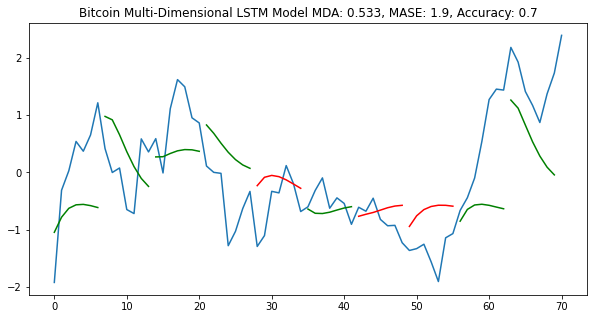

In [59]:
btc_cols = ['linreg', 'percent_change_24h_rank', 'social_volume_24h_rank', 'tweet_sentiment_bullish']

cols = [*[target_col], * btc_cols]
# Scale data based on new cols list
btc_data, btc_train_scaled, btc_test_scaled, btc_scaler = data_preprocessing_standardize(standard_scaler, btc, cols,
                                                                                     test_periods, total_len)
# Create train/test datasets
btc_train_X, btc_train_y, btc_train_targets = create_timeseries_data(btc_train_scaled, target_col, input_len, steps_ahead)
btc_test_X, btc_test_y, btc_test_targets = create_timeseries_data(btc_test_scaled, target_col, input_len, steps_ahead)

btc_model_config = update_model_input_dim(lstm_config, btc_train_X.shape, btc_train_y.shape)

# Increase learning rate
btc_model_config['model']['optimizer']['learning_rate'] = 0.01

# Set verbose to on
btc_train_config['verbose'] = 1

# Run checkpoints
btc_train_config['model_checkpoint'] = True

# Instantiate model class
btc_lstm_model = Model()

# Build model
btc_lstm_model.build_model(btc_model_config)

btc_lstm_model.train(btc_train_X, btc_train_y, btc_train_config)

btc_predictions, btc_seq_metrics = evaluate_model(btc_lstm_model, btc_test_X, btc_test_y, 
                                                  total_len, prediction_len, steps_ahead)

btc_mda = mean_metric_results(btc_seq_metrics, 'mda')
btc_mase = mean_metric_results(btc_seq_metrics, 'mase')
btc_acc = mean_accuracy(btc_seq_metrics)

title = 'Bitcoin Multi-Dimensional LSTM Model MDA: {:.3}, MASE: {:.3}, Accuracy: {:.3}'.format(btc_mda, 
                                                                                        btc_mase,
                                                                                        btc_acc)
plot_results_multiple(btc_predictions, btc_test_y, prediction_len, title)

Improved sequence prediction accuracy from .48 to .7.

##### Dogecoin

In [60]:
doge_search_cols = list(doge.drop(['asset_id', 'time', 'open', 'close', 'name', 'symbol', 'price_btc',
                             'close_end_1d', 'close_percent_change_1d', 'close_end_7d', 'close_min_7d', 
                             'close_max_7d', 'close_loss_7d', 'close_gain_7d', 'close_change_7d', 
                             'close_percent_change_7d', 'decision','color','angle', 'intercept']
                            , axis=1).columns)

In [61]:
# Set verbose to off since training many models
doge_train_config['verbose'] = 0
# Do not run checkpoints
doge_train_config['model_checkpoint'] = False
# For the first run for all columns set training runs to 1
training_runs = 1
doge_search_results = model_training_search_cols(doge_search_cols, training_runs, target_col, standard_scaler, doge, 
                                                test_periods, input_len, total_len, prediction_len, steps_ahead,
                                                doge_train_config, doge_base_sw_acc)

LSTM model trained with "url_shares". 1 training run(s) trend accuracy of 0.8.
LSTM model trained with "tweets". 1 training run(s) trend accuracy of 0.7.
LSTM model trained with "tweet_sentiment2". 1 training run(s) trend accuracy of 0.7.
LSTM model trained with "tweet_sentiment3". 1 training run(s) trend accuracy of 0.8.
LSTM model trained with "tweet_sentiment4". 1 training run(s) trend accuracy of 0.7.
LSTM model trained with "tweet_sentiment5". 1 training run(s) trend accuracy of 0.7.
LSTM model trained with "tweet_sentiment_impact4". 1 training run(s) trend accuracy of 0.7.
LSTM model trained with "tweet_sentiment_impact5". 1 training run(s) trend accuracy of 0.7.
LSTM model trained with "social_score". 1 training run(s) trend accuracy of 0.7.
LSTM model trained with "average_sentiment". 1 training run(s) trend accuracy of 0.8.
LSTM model trained with "news". 1 training run(s) trend accuracy of 0.7.
LSTM model trained with "galaxy_score". 1 training run(s) trend accuracy of 0.7.
L

In [62]:
doge_search_results_df = pd.DataFrame(doge_search_results).T

# Top 20 by accuracy
doge_search_results_df.sort_values(by='accuracy', ascending=False).head(20)

,mda,mase,accuracy
social_volume_global,0.583333,4.003101,0.9
tweet_sentiment3,0.500000,3.225490,0.8
social_volume_global_mean,0.583333,3.007135,0.8
tweet_sentiment_impact_net_mean,0.550000,3.219884,0.8
tweet_sentiment_impact_net,0.583333,5.088911,0.8
tweet_sentiment_bullish,0.500000,3.848558,0.8
slope,0.600000,4.434367,0.8
cci,0.616667,2.670420,0.8
average_sentiment,0.500000,6.387620,0.8
market_cap_global_pct_change,0.550000,3.197458,0.8


In [63]:
# Top 10 by mda
doge_search_results_df.sort_values(by='mda', ascending=False).head(10)

,mda,mase,accuracy
roc,0.666667,4.228509,0.6
market_cap_global,0.650000,2.720715,0.6
url_shares,0.633333,2.578706,0.8
tweet_sentiment_impact_bearish_stdev,0.616667,2.490404,0.7
cci,0.616667,2.670420,0.8
tweet_replies,0.616667,3.271472,0.6
high,0.600000,2.463028,0.6
tweet_sentiment_impact4,0.600000,2.803499,0.7
tweet_sentiment4,0.600000,3.365137,0.7
slope,0.600000,4.434367,0.8


In [64]:
# Top 10 by mase
doge_search_results_df.sort_values(by='mase', ascending=True).head(10)

,mda,mase,accuracy
bband_lower,0.583333,1.656383,0.7
tweets_mean,0.500000,1.903424,0.7
macd,0.600000,2.057214,0.7
tweet_sentiment_bearish,0.583333,2.070001,0.6
news_mean,0.500000,2.247926,0.6
tweet_sentiment_impact_bullish,0.566667,2.365031,0.7
sentiment_relative,0.566667,2.372999,0.6
ppo,0.500000,2.438950,0.6
cmo,0.500000,2.459118,0.7
high,0.600000,2.463028,0.6


In [68]:
doge_search_final_cols = ['tsf', 'linreg', 'roc', 'cci', 'macd',
                          'market_cap_global', 'market_cap_global_pct_change', 'social_impact_score', 'price_score',
                          'social_volume_global', 'social_volume_global_mean', 'url_shares', 'galaxy_score',
                          'tweet_sentiment_bearish', 'tweet_sentiment_bullish',
                          'tweet_sentiment_impact3', 'tweet_sentiment_impact_bullish', 
                          'tweet_sentiment_impact_net', 'tweet_sentiment_impact_net_mean',
                           'tweet_sentiment_impact_bearish_stdev', 'average_sentiment']

print(len(doge_search_final_cols))

21


In [69]:
# Set verbose to off since training many models
doge_train_config['verbose'] = 0
# Do not run checkpoints
doge_train_config['model_checkpoint'] = False
# For exhaustive search limit runs to 5
training_runs = 5
doge_search_results_final = model_training_search_cols(doge_search_final_cols, training_runs, target_col, 
                                                      standard_scaler, doge, 
                                                      test_periods, input_len, total_len, prediction_len, steps_ahead,
                                                      doge_train_config, doge_base_sw_acc, verbose=True)

LSTM model trained with "tsf". 5 training run(s) trend accuracy of 0.62.
LSTM model trained with "linreg". 5 training run(s) trend accuracy of 0.72.
LSTM model trained with "roc". 5 training run(s) trend accuracy of 0.64.
LSTM model trained with "cci". 5 training run(s) trend accuracy of 0.6.
LSTM model trained with "macd". 5 training run(s) trend accuracy of 0.68.
LSTM model trained with "market_cap_global". 5 training run(s) trend accuracy of 0.7.
LSTM model trained with "market_cap_global_pct_change". 5 training run(s) trend accuracy of 0.74.
LSTM model trained with "social_impact_score". 5 training run(s) trend accuracy of 0.64.
LSTM model trained with "price_score". 5 training run(s) trend accuracy of 0.7.
LSTM model trained with "social_volume_global". 5 training run(s) trend accuracy of 0.68.
LSTM model trained with "social_volume_global_mean". 5 training run(s) trend accuracy of 0.76.
LSTM model trained with "url_shares". 5 training run(s) trend accuracy of 0.76.
LSTM model tra

Epoch 1/40
14/14 [==============================] - 6s 200ms/step - loss: 0.7196 - val_loss: 0.7203
Epoch 2/40
14/14 [==============================] - 2s 125ms/step - loss: 0.6241 - val_loss: 0.6687
Epoch 3/40
14/14 [==============================] - 2s 143ms/step - loss: 0.4867 - val_loss: 0.6329
Epoch 4/40
14/14 [==============================] - 3s 206ms/step - loss: 0.4270 - val_loss: 0.5332
Epoch 5/40
14/14 [==============================] - 4s 251ms/step - loss: 0.3736 - val_loss: 0.5694
Epoch 6/40
14/14 [==============================] - 4s 303ms/step - loss: 0.4118 - val_loss: 0.6059
Epoch 7/40
14/14 [==============================] - 4s 284ms/step - loss: 0.3803 - val_loss: 0.5366


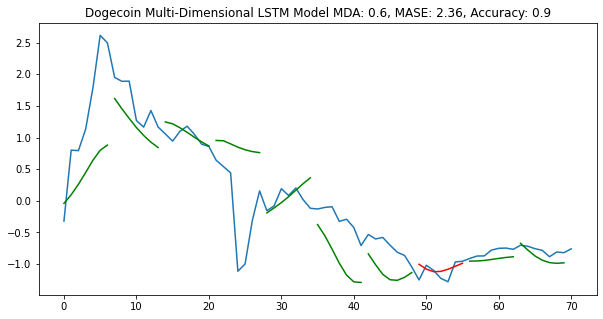

In [72]:
doge_cols = ['linreg', 'market_cap_global_pct_change', 'social_volume_global_mean', 'tweet_sentiment_impact_net_mean']

cols = [*[target_col], * doge_cols]
# Scale data based on new cols list
doge_data, doge_train_scaled, doge_test_scaled, doge_scalers = data_preprocessing_standardize(standard_scaler, doge, 
                                                                                              cols, test_periods, total_len)
# Create train/test datasets
doge_train_X, doge_train_y, doge_train_targets = create_timeseries_data(doge_train_scaled, target_col, 
                                                                        input_len, steps_ahead)
doge_test_X, doge_test_y, doge_test_targets = create_timeseries_data(doge_test_scaled, target_col, 
                                                  input_len, steps_ahead)

doge_model_config = update_model_input_dim(lstm_config, doge_train_X.shape, doge_train_y.shape)

# Increase learning rate
doge_model_config['model']['optimizer']['learning_rate'] = 0.01

# Set verbose to on
doge_train_config['verbose'] = 1

# Run checkpoints
doge_train_config['model_checkpoint'] = True

# Instantiate model class
doge_lstm_model = Model()

# Build model
doge_lstm_model.build_model(doge_model_config)

doge_lstm_model.train(doge_train_X, doge_train_y, doge_train_config)

doge_predictions, doge_seq_metrics = evaluate_model(doge_lstm_model, doge_test_X, doge_test_y, 
                                                    total_len, prediction_len, steps_ahead)

doge_mda = mean_metric_results(doge_seq_metrics, 'mda')
doge_mase = mean_metric_results(doge_seq_metrics, 'mase')
doge_acc = mean_accuracy(doge_seq_metrics)

title = 'Dogecoin Multi-Dimensional LSTM Model MDA: {:.3}, MASE: {:.3}, Accuracy: {:.3}'.format(doge_mda, 
                                                                                        doge_mase,
                                                                                        doge_acc)
plot_results_multiple(doge_predictions, doge_test_y, prediction_len, title)

Improved sequence prediction accuracy from .62 to .9.